In [ ]:
import pandas as pd
import seaborn as sns
import path_config
sns.set_theme() 

In [ ]:
from lib.utils_plotting import print_avg_results, results_file, get_mae

results,results_w_regions = results_file("test")
results_val, results_w_regions_val = results_file("val")
	
from lib.utils_plotting import convex_ensemble
for m1, m2 in [("prithvi_pretrained_1.0", "shallow_transformer_pixels_1.0")]:
	base_methods = [m1, m2]

	out_key = f"Ensemble {', '.join(base_methods)}"
	models_dbg = convex_ensemble(
		base_methods,
		results_w_regions_val,
		results_w_regions,
		out_name=out_key,
		region_col='NA_L1NAME',
	)

results_mae = {"HLStile": [], "Date": [], "MAE": [], "Method": [], "SiteID": []}
for tile, siteid in results_w_regions["prithvi_pretrained_1.0_test"][["HLStile", "SiteID"]].drop_duplicates().values:
    for key in results_w_regions.keys(): 
        results_mae = get_mae(results_w_regions[key], tile, siteid, results_mae, key)

results_mae_df = pd.DataFrame(results_mae)

## A- Overview of methods' results

1- The Shallow Temporal only Transformer from prior work performs the best. 

2- The Shallow Temporal model trained in our data gets pretty close to the same model trained on prior work data. 

3- Pretraining improves the performance of Prithvi. 

4- Complete Fine tuning performs better than LORA. 

In [9]:
methods_to_print = ["prithvi_lora_1.0_test", "prithvi_pretrained_1.0_test", "prithvi_random_1.0_test", "shallow_transformer_pixels_1.0_test", "shallow_transformer_pixels_priorwork_data_test"]
avg_results = print_avg_results(methods_to_print, results_mae_df)

                                                   G     M     S     D  Mean
Method                                                                      
prithvi_lora_1.0_test                           16.8  17.9  25.9  26.0  21.7
prithvi_pretrained_1.0_test                     15.9  15.3  21.8  21.2  18.5
prithvi_random_1.0_test                         17.8  18.7  26.1  26.8  22.3
shallow_transformer_pixels_1.0_test             13.6  12.8  19.9  20.8  16.8
shallow_transformer_pixels_priorwork_data_test  13.3  10.7  16.4  15.1  13.9


## B- Patch Size Effect on Performance

Phenology is predominantely a temporal task (temporal signal > spatial signal). Therefore, temporal attention on a more fine grained scale is important. However, when spatial patch size increases, temporal attention weakens. To verify this, we train prior work shallow temporal model on an ever increasing patch size. Results below indicate that larger patch sizes substanatially weakens temporal modelling

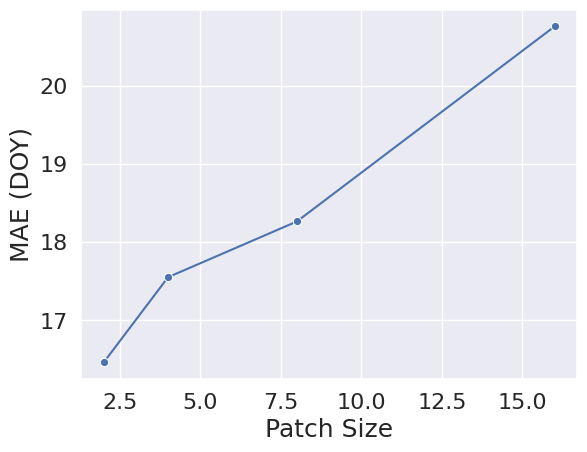

In [10]:
methods = [] 

patch_results = {
    "Patch Size": [],
    "MAE": [],
}

for patch_size in [2, 4, 8, 16]:
    method = f"shallow_transformer_patch{patch_size}_1.0_test"
    patch_results["Patch Size"].append(patch_size)
    patch_results["MAE"].append(results_mae_df[results_mae_df["Method"] == method]["MAE"].mean())

patch_results = pd.DataFrame(patch_results)

ax =  sns.lineplot(x="Patch Size", y="MAE", data=patch_results, marker="o")
ax.set_xlabel("Patch Size", fontsize=18)
ax.set_ylabel("MAE (DOY)", fontsize=18)
ax.tick_params(axis='both', labelsize=16)

## C- Does Prithvi have any advantges? 

We split performance per eco region. We note that: 

1- Prithvi performs substantially better on the North American Deserts region. 

2- This improvements disappears when the pretraining is absent highlighting its significance. 

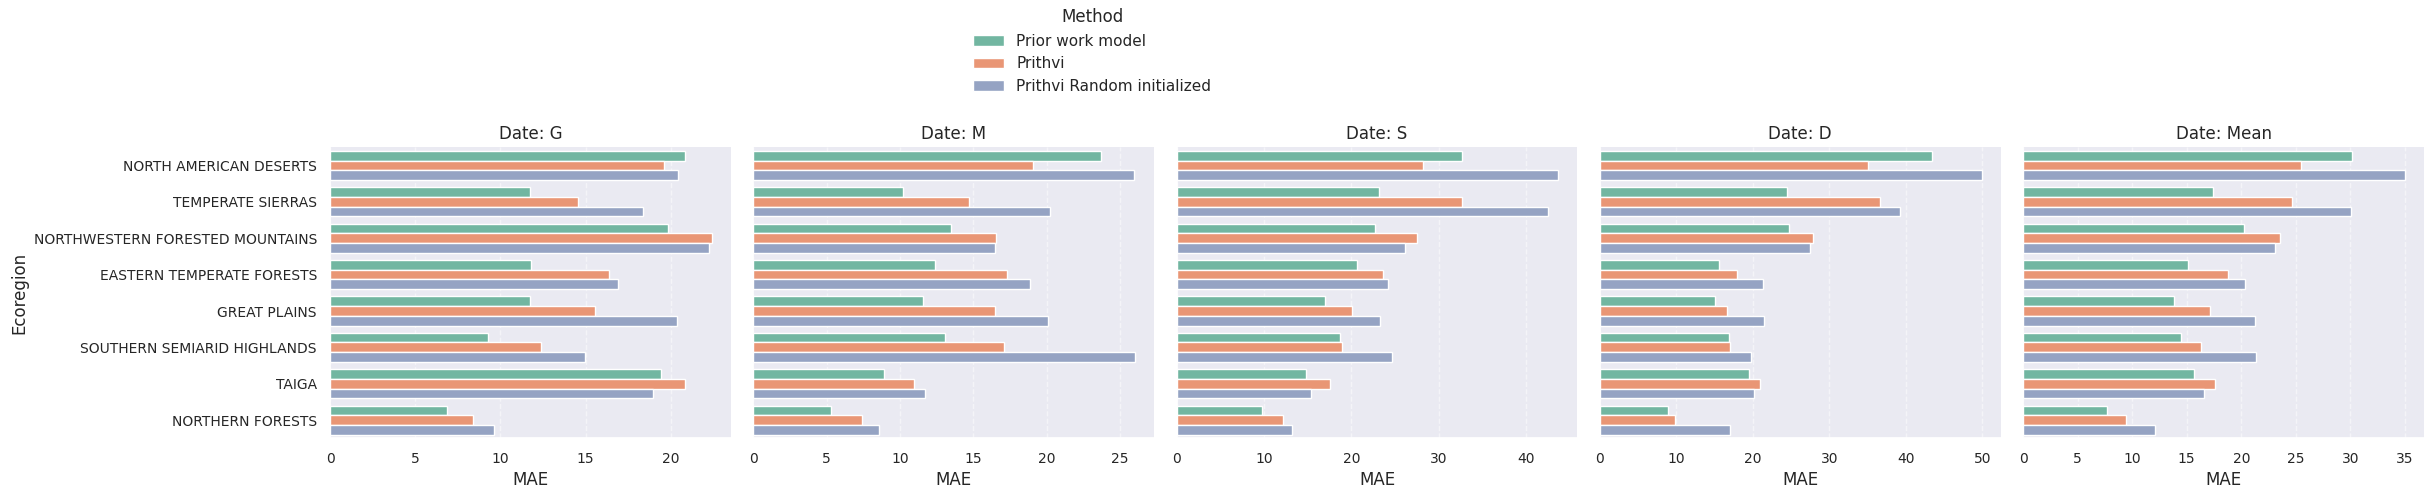

In [ ]:
from lib.utils_plotting import plot_methods_regions_split

results_mae_df_ = results_mae_df.copy()
results_mae_df_["Method"] = results_mae_df_["Method"].replace("shallow_transformer_pixels_1.0_test", "Prior work model")
results_mae_df_["Method"] = results_mae_df_["Method"].replace("prithvi_pretrained_1.0_test", "Prithvi Pretrained")
results_mae_df_["Method"] = results_mae_df_["Method"].replace("prithvi_random_1.0_test", "Prithvi Randomly initialized")

plot_methods_regions_split(results_mae_df_, 
                            geo_path=path_config.get_data_geojson(),
                            eco_path="../useco1/NA_CEC_Eco_Level1.shp",
                            methods=["Prior work model", "Prithvi Pretrained", "Prithvi Randomly initialized"],
                         )

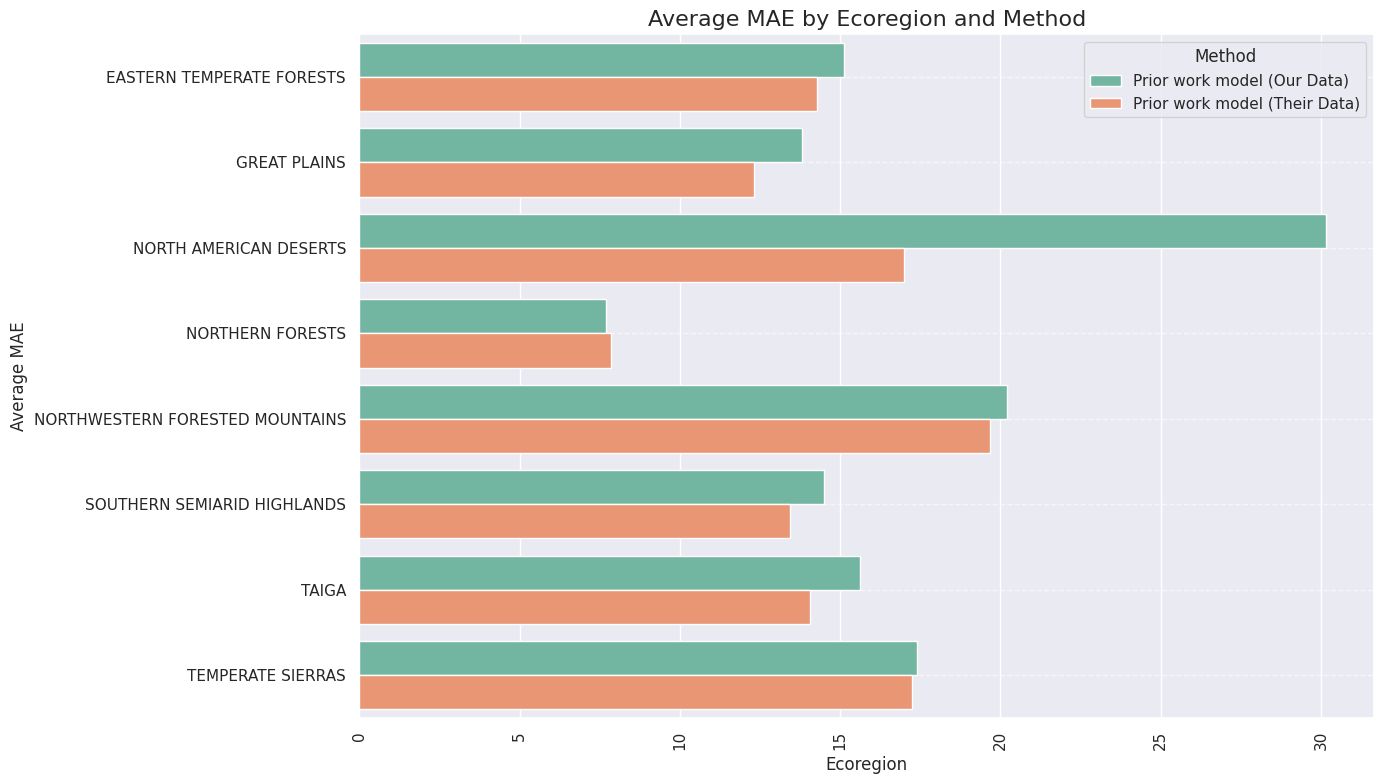

In [ ]:
from lib.utils_plotting import  plot_methods_regions

results_mae_df_ = results_mae_df.copy()
results_mae_df_["Method"] = results_mae_df_["Method"].replace("shallow_transformer_pixels_1.0_test", "Prior work model (Our Data)")
results_mae_df_["Method"] = results_mae_df_["Method"].replace("shallow_transformer_pixels_priorwork_data_test", "Prior work model (Their Data)")


# plot_methods_regions(results_mae_map, methods=["1D Shallow Transformer (Our Data),1.0,all", "Prithvi-Pretraining (Our Data),1.0,all"])
plot_methods_regions(results_mae_df_, 
                     methods=["Prior work model (Our Data)", "Prior work model (Their Data)"],
                        geo_path=path_config.get_data_geojson(),
                        eco_path="../useco1/NA_CEC_Eco_Level1.shp",
                     )

### D- Can we make use of this improved performance? 

We propose to use an Ensemble model that combines prior work shallow transformer and Prithvi outputs. Observe below that ensemble model significantly improves average performance, especially on north american deserts region. 

In [14]:
methods_to_print = ["prithvi_pretrained_1.0_test", "shallow_transformer_pixels_1.0_test", "Ensemble prithvi_pretrained_1.0, shallow_transformer_pixels_1.0"]
avg_results = print_avg_results(methods_to_print, results_mae_df)

                                                                    G     M     S     D  Mean
Method                                                                                       
prithvi_pretrained_1.0_test                                      15.9  15.3  21.8  21.2  18.5
shallow_transformer_pixels_1.0_test                              13.6  12.8  19.9  20.8  16.8
Ensemble prithvi_pretrained_1.0, shallow_transformer_pixels_1.0  13.3  12.5  19.3  19.4  16.1


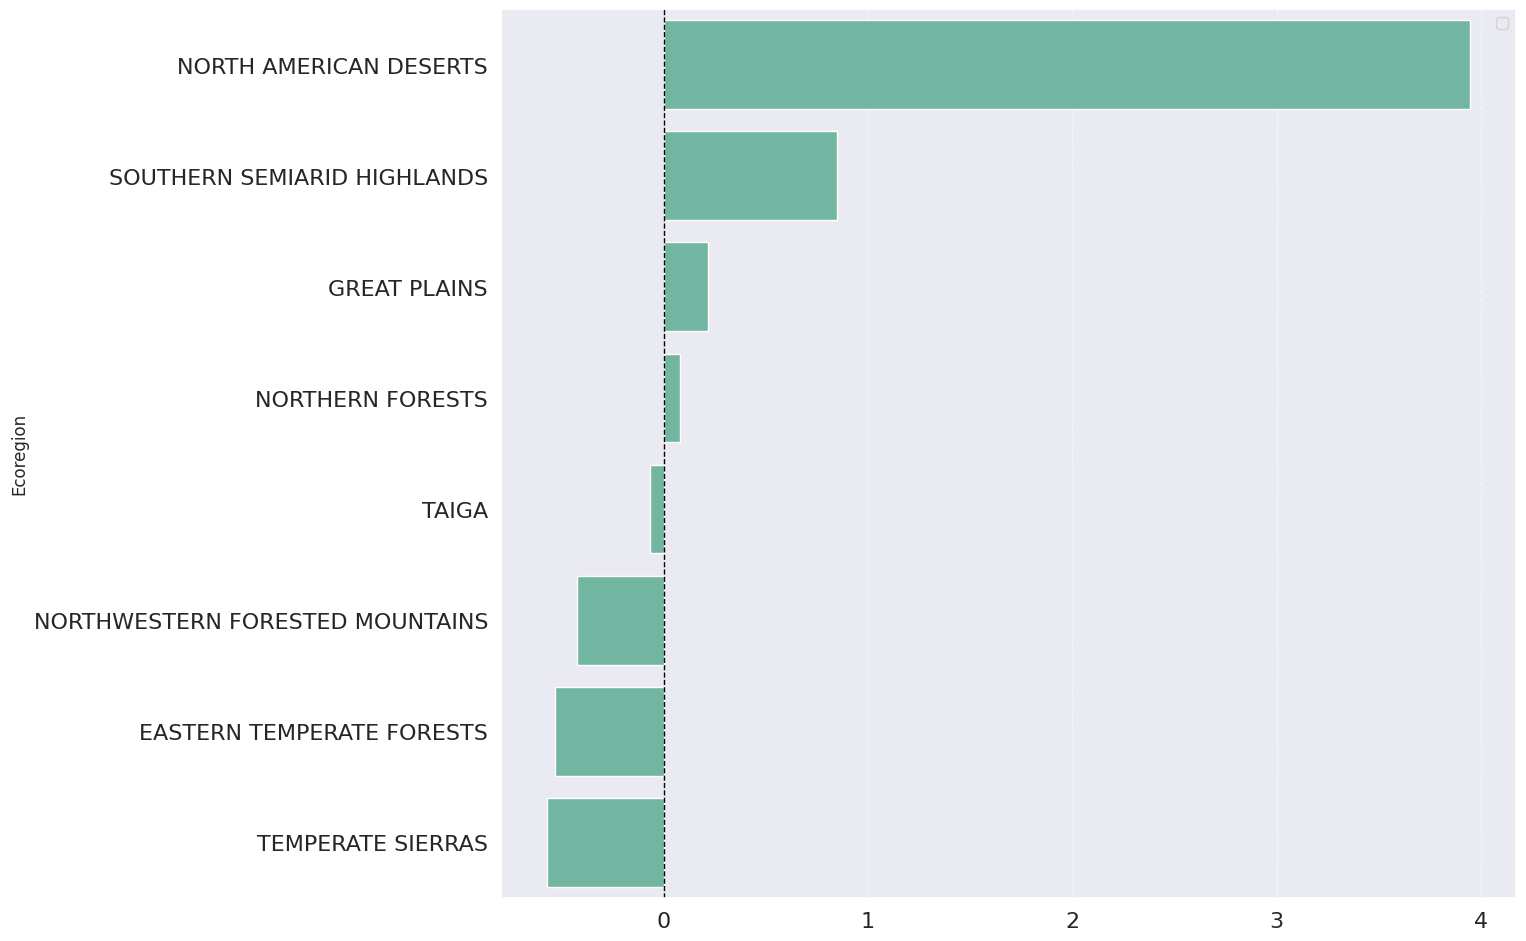

In [ ]:
from lib.utils_plotting import plot_mae_improvement_by_region

results_mae_df_ = results_mae_df.copy()
plot_mae_improvement_by_region(
    results_mae_df_,
    geo_path=path_config.get_data_geojson(),
    eco_path="../useco1/NA_CEC_Eco_Level1.shp",
    methods_to_compare=["Ensemble prithvi_pretrained_1.0, shallow_transformer_pixels_1.0"],
    anchor_method="shallow_transformer_pixels_1.0_test",
    figsize=(14, 10)
)

## E- Qual Results

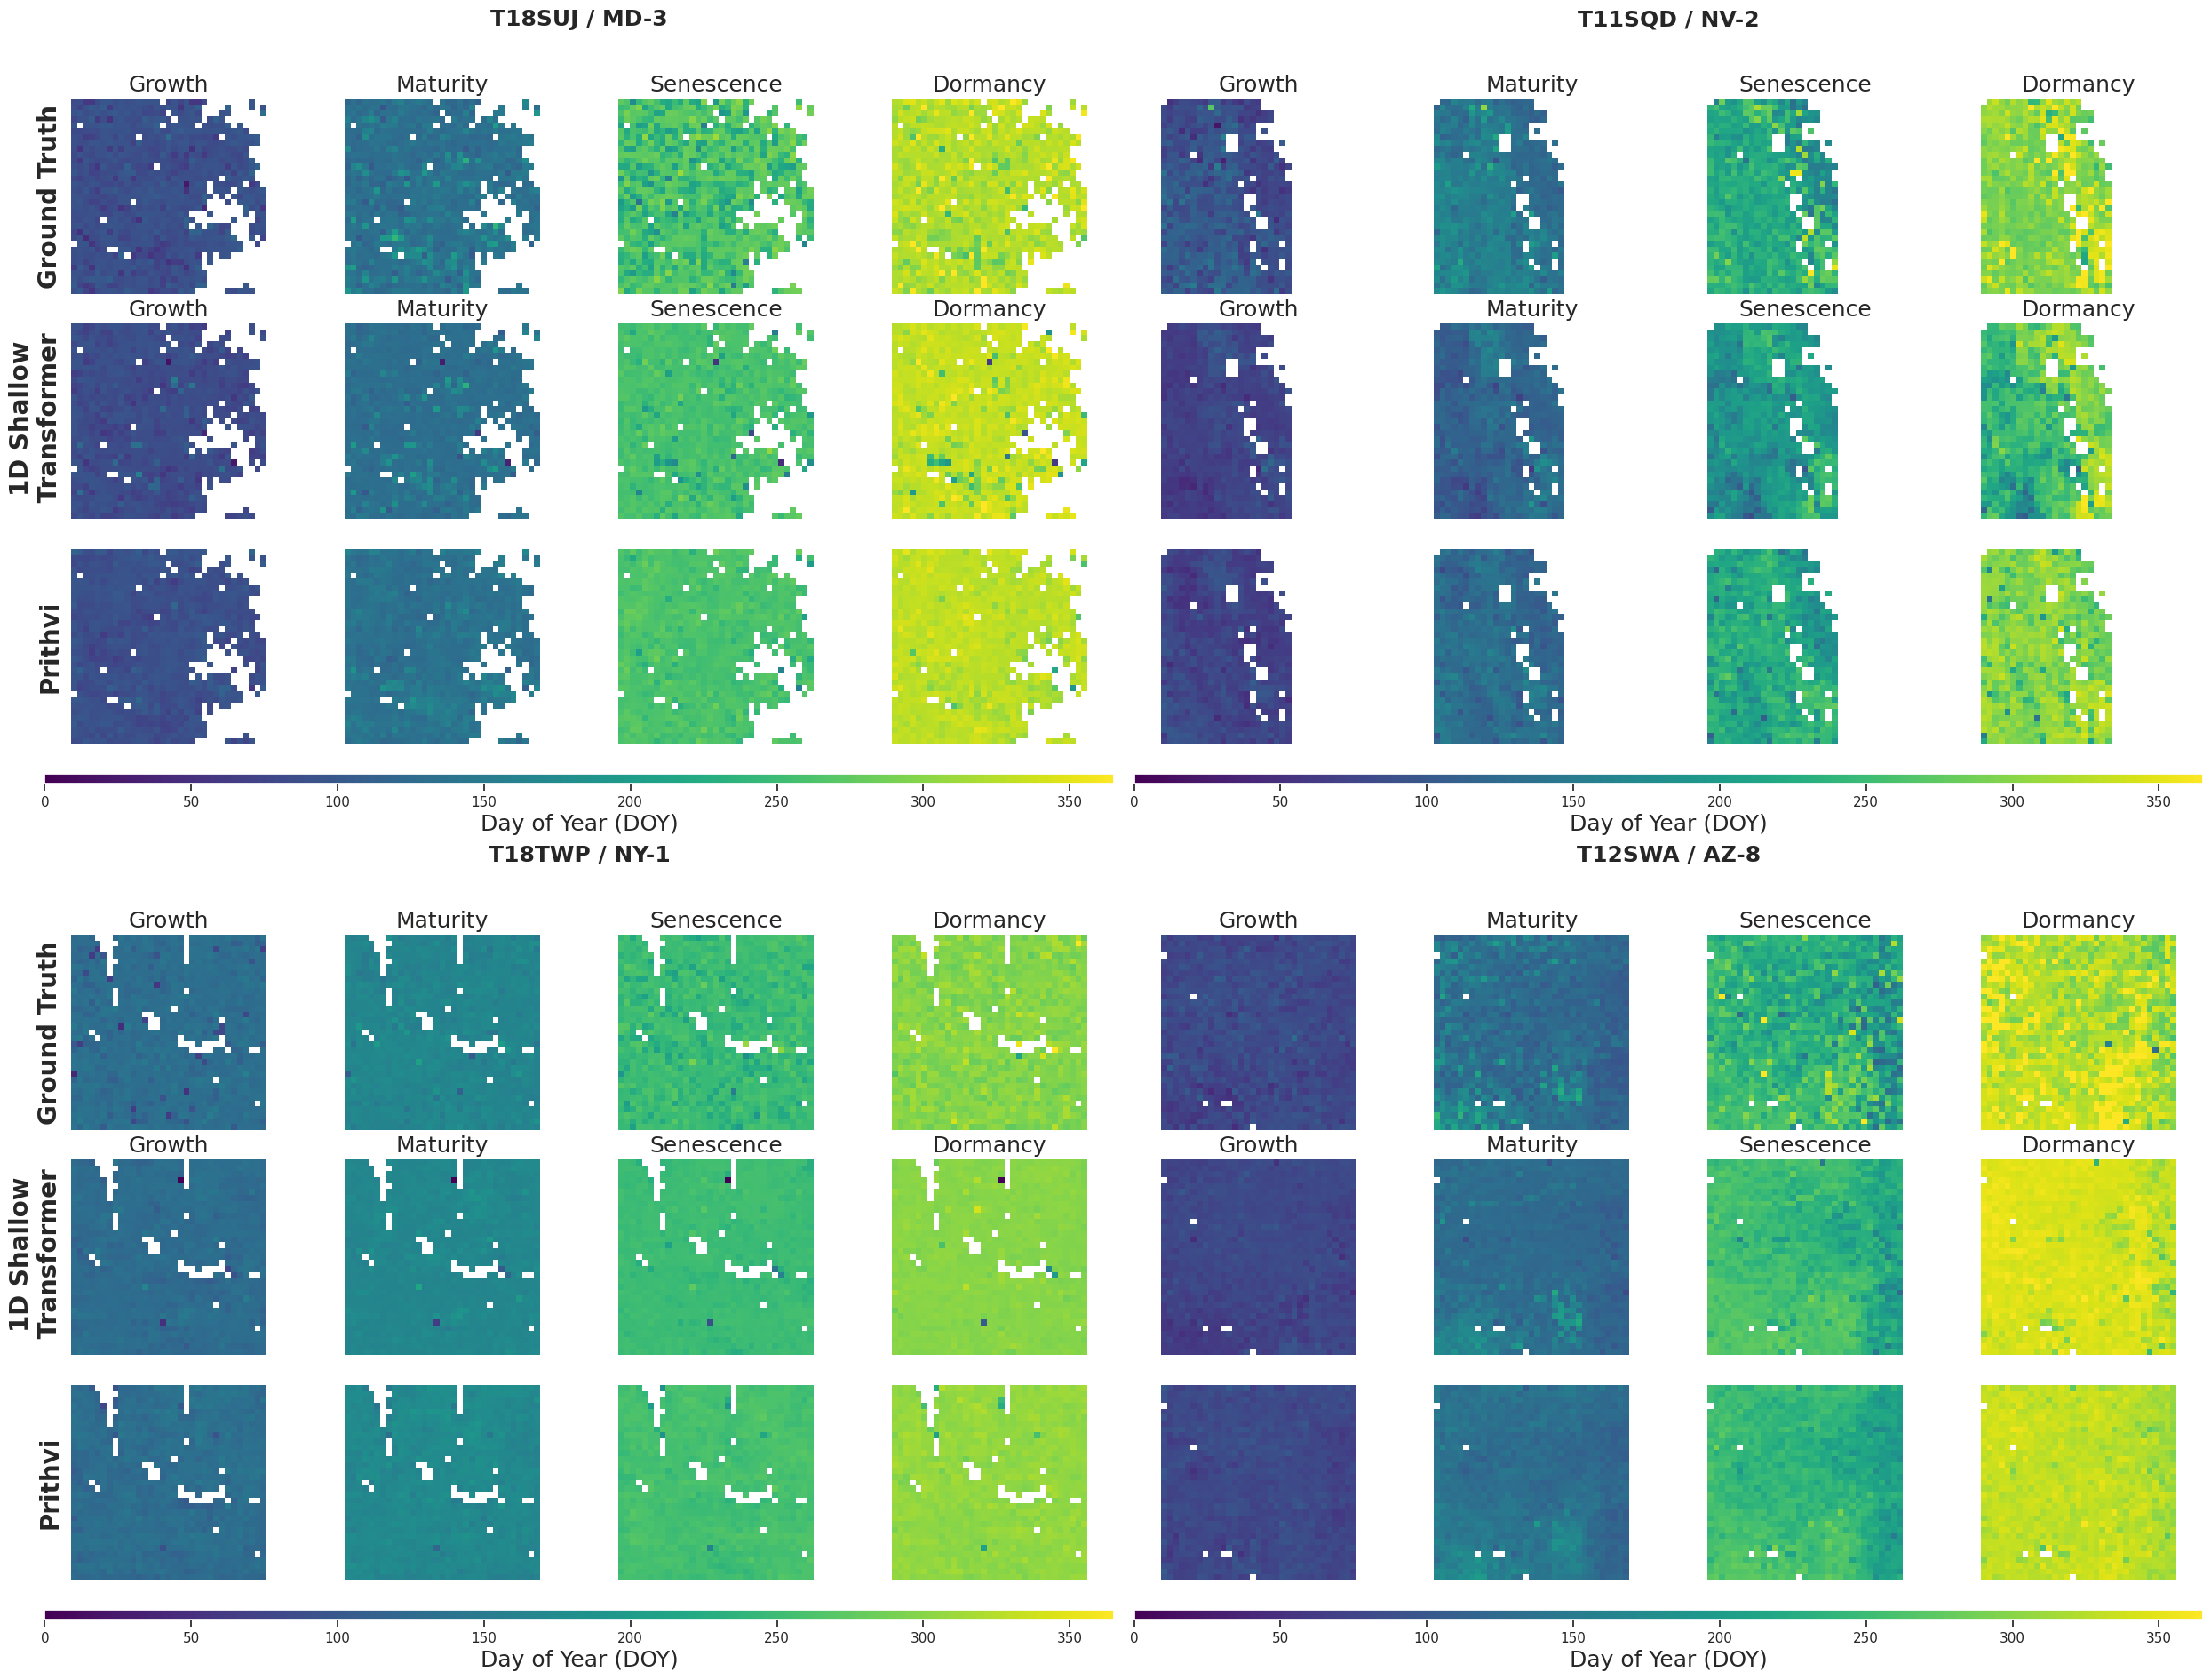

In [ ]:
from lib.utils_plotting import plot_qual
plot_qual(results_w_regions, methods = ["prithvi_pretrained_1.0_test", "shallow_transformer_pixels_1.0_test"], methods_plot_names = ["Prithvi", "1D Shallow \n Transformer"])

# C- Full Quant Results

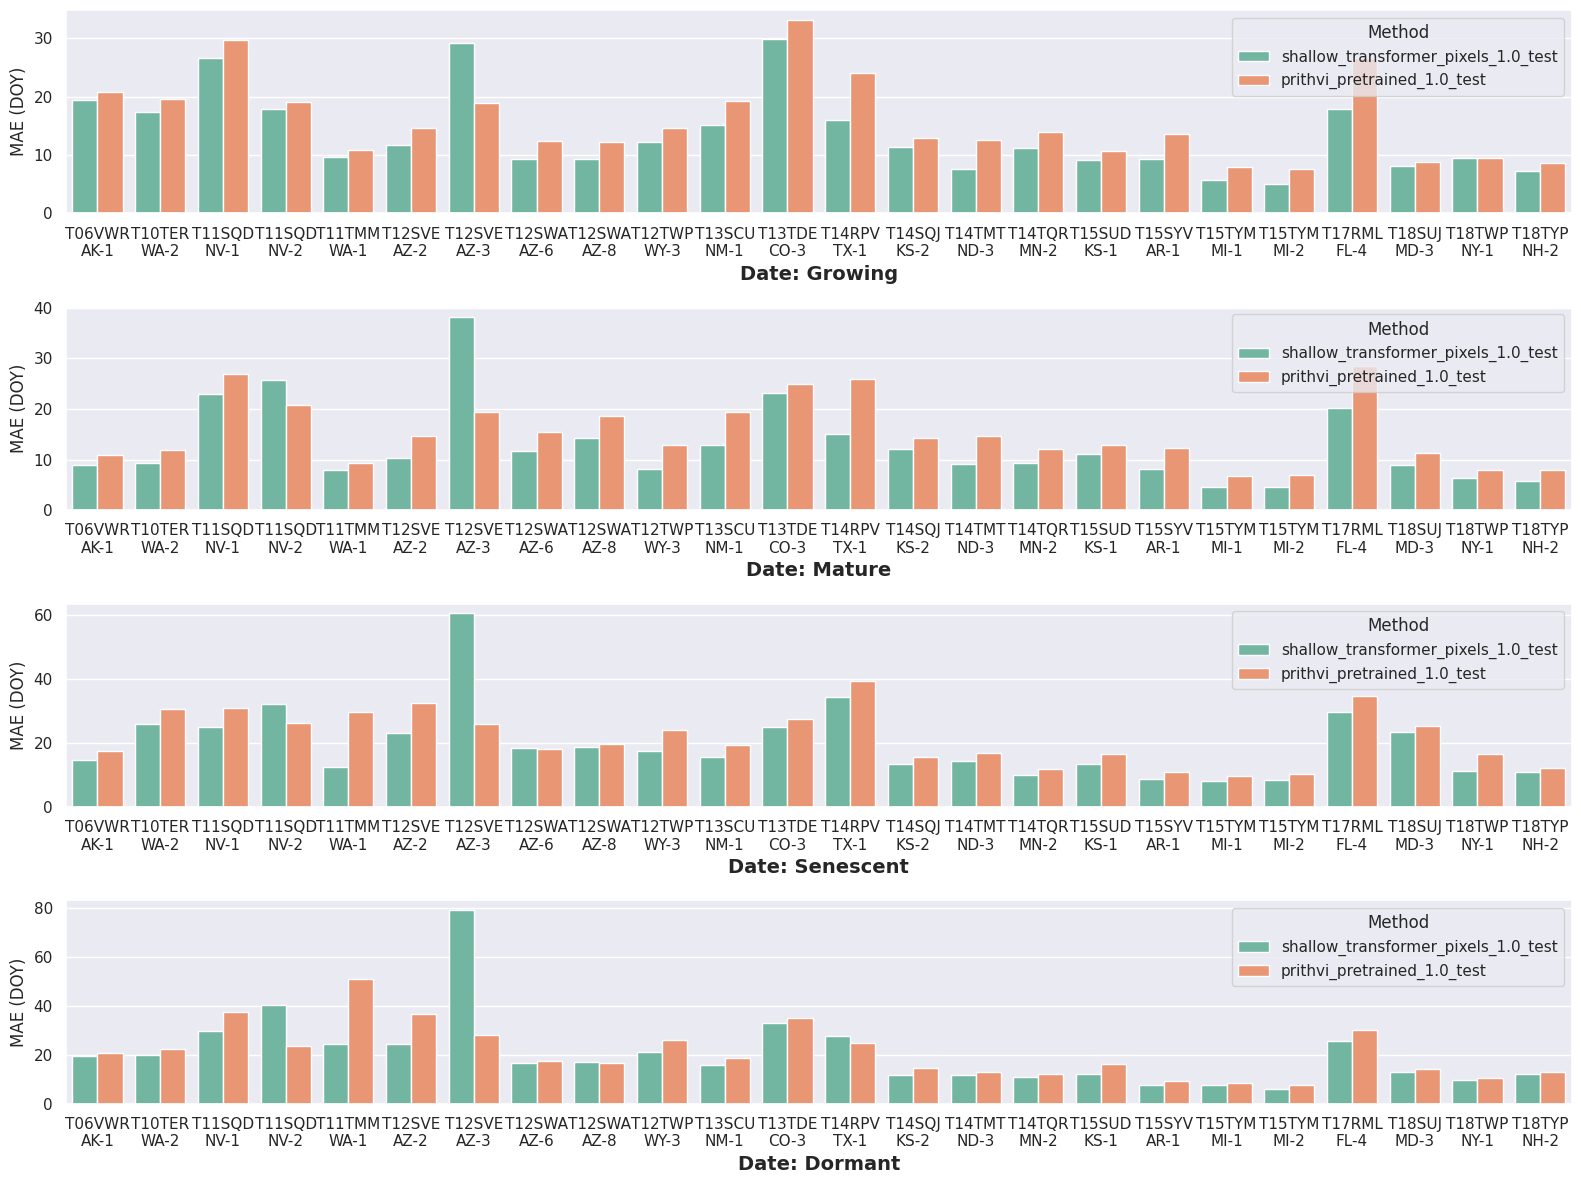

In [ ]:
from lib.utils_plotting import plot_performance_tiles
plot_performance_tiles(results_mae_df, methods= ["prithvi_pretrained_1.0_test", "shallow_transformer_pixels_1.0_test"])